Using MAX_LEN=625 for 20.0 seconds of audio
Using MAX_LEN=625 for 20.0 seconds of audio


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]



🧪 Epoch 1 | Train Loss: 1.1932
4    370
0     39
1      8
3      1
Name: count, dtype: int64

📊 Val — Acc: 0.5861 | Prec: 0.4496 | Rec: 0.2917 | F1: 0.2558
✅ Best model saved!

🧪 Epoch 2 | Train Loss: 0.9939
4    237
3    108
0     45
1     28
Name: count, dtype: int64

📊 Val — Acc: 0.5359 | Prec: 0.3677 | Rec: 0.4424 | F1: 0.3891

🧪 Epoch 3 | Train Loss: 0.8779
4    315
3     51
2     36
1     14
0      2
Name: count, dtype: int64

📊 Val — Acc: 0.6531 | Prec: 0.6870 | Rec: 0.4245 | F1: 0.4476
✅ Best model saved!

🧪 Epoch 4 | Train Loss: 0.7538
4    220
1     65
0     48
3     47
2     38
Name: count, dtype: int64

📊 Val — Acc: 0.6770 | Prec: 0.6146 | Rec: 0.6474 | F1: 0.6160
✅ Best model saved!

🧪 Epoch 5 | Train Loss: 0.6642
4    206
3     78
2     77
1     36
0     21
Name: count, dtype: int64

📊 Val — Acc: 0.6986 | Prec: 0.6814 | Rec: 0.6840 | F1: 0.6654
✅ Best model saved!

🧪 Epoch 6 | Train Loss: 0.5910
4    223
2    124
0     26
3     23
1     22
Name: count, dtype: int64

📊 Va

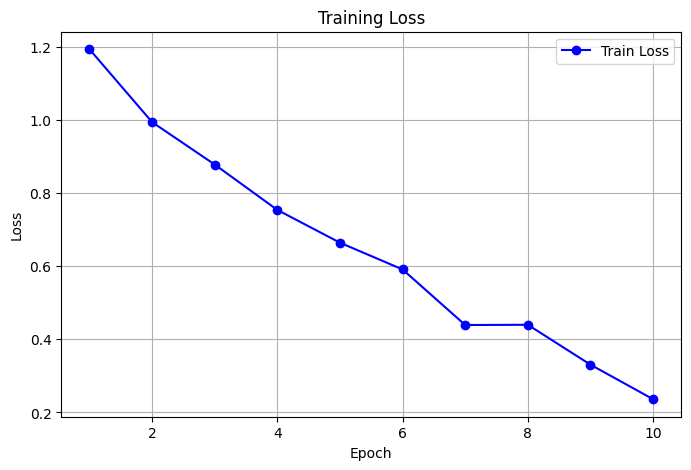

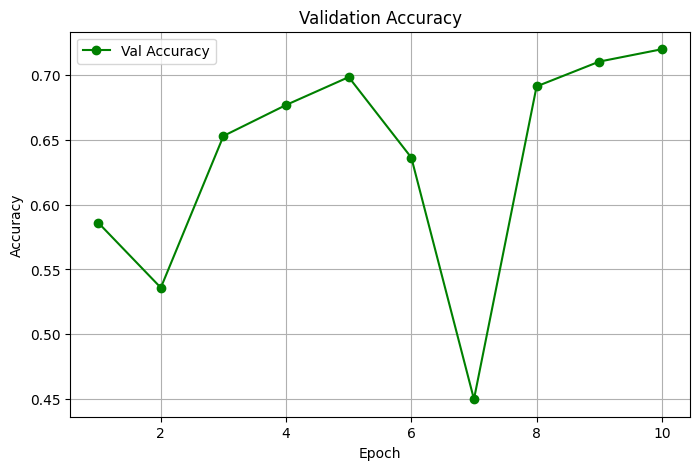

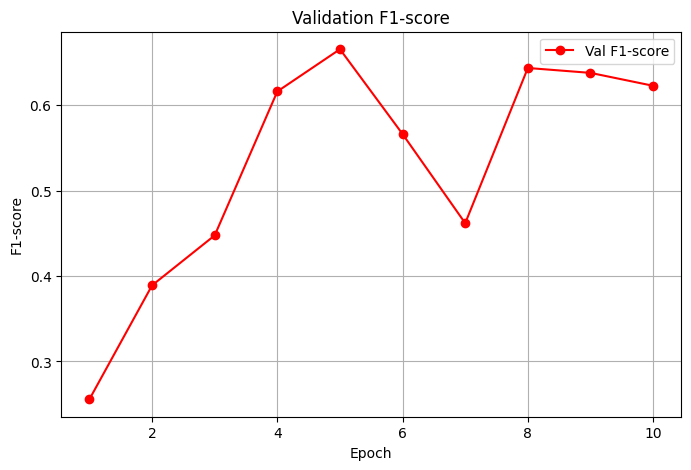

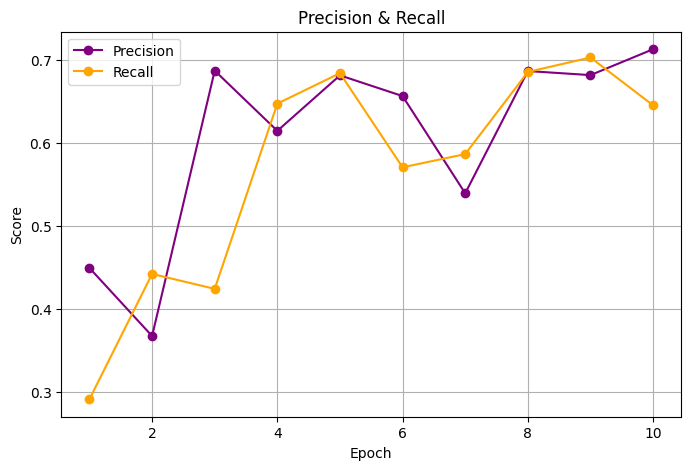

'/content/multi_model_backup.zip'

In [ ]:
import os
import torch
import torchaudio
import torchvision.models as models
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Dataset ====
class HeartbeatDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB(stype='power')
        self.resampler = torchaudio.transforms.Resample(orig_freq=44100, new_freq=16000)

        frame_duration = 512 / 16000  # 0.032 sec
        target_duration = 20.0        # 20 seconds
        self.MAX_LEN = int(target_duration / frame_duration)  # 625 frames
        print(f"Using MAX_LEN={self.MAX_LEN} for {target_duration} seconds of audio")

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform, sr = torchaudio.load(row["filepath"])
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            waveform = resampler(waveform)

        mel_spec = self.mel_transform(waveform)
        mel_spec = self.db_transform(mel_spec)
        mel_spec = mel_spec.expand(3, -1, -1)

        if mel_spec.shape[2] < self.MAX_LEN:
            pad_width = self.MAX_LEN - mel_spec.shape[2]
            mel_spec = torch.nn.functional.pad(mel_spec, (0, pad_width))
        else:
            mel_spec = mel_spec[:, :, :self.MAX_LEN]

        demo = torch.tensor([
            float(row["Age"]) / 100.0,
            float(row["Gender"]),
            float(row["Smoker"]),
            float(row["Lives"])
        ], dtype=torch.float)

        label = torch.tensor(int(row["class_id"]), dtype=torch.long)
        return mel_spec, demo, label

    def __len__(self):
        return len(self.df)

# ==== Collate ====
def collate_fn(batch):
    specs, demos, labels = zip(*batch)
    return torch.stack(specs), torch.stack(demos), torch.tensor(labels)

# ==== Model ====
class ResNetWithDemographics(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn.fc = nn.Identity()

        self.demographic = nn.Linear(4, 32)

        self.classifier = nn.Sequential(
            nn.Linear(512 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, demo):
        cnn_feat = self.cnn(x)
        demo_feat = self.demographic(demo)
        combined = torch.cat([cnn_feat, demo_feat], dim=1)
        return self.classifier(combined)

# ==== Build DataFrame ====
def build_dataframe(base_dir, metadata_csv):
    meta = pd.read_csv(metadata_csv)
    data = []

    class_mapping = {
        "aortic_regurgitation": 0,
        "aortic_stenosis": 1,
        "mitral_regurgitation": 2,
        "mitral_stenosis": 3,
        "multi_disease": 4
    }

    for class_name, class_id in class_mapping.items():
        folder_path = os.path.join(base_dir, class_name)
        for fname in os.listdir(folder_path):
            if fname.endswith(".wav"):
                patient_num = fname.split("_")[3]
                patient_id = f"patient_{patient_num}"
                match = meta[meta["Patient_id"] == patient_id]
                if not match.empty:
                    row = match.iloc[0].to_dict()
                    row["filepath"] = os.path.join(folder_path, fname)
                    row["class_id"] = class_id
                    data.append(row)

    return pd.DataFrame(data), class_mapping

# ==== Evaluate ====
def evaluate_model(model, val_loader, num_classes):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for x, demo, label in val_loader:
            x, demo = x.to(device), demo.to(device)
            logits = model(x, demo)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            true = label.numpy()
            preds.extend(pred)
            trues.extend(true)

    acc = accuracy_score(trues, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(trues, preds, average="macro", zero_division=0)
    print(pd.Series(preds).value_counts())
    print(f"\n📊 Val — Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
    return acc, prec, rec, f1

# ==== Load & Train ====
df, class_mapping = build_dataframe(
    "/content/drive/MyDrive/multi_classification_model_data",
    "/content/drive/MyDrive/multi_classification_model_data/metadata.csv"
)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["class_id"], random_state=42)

train_ds = HeartbeatDataset(train_df)
val_ds = HeartbeatDataset(val_df)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collate_fn)

num_classes = len(class_mapping)
model = ResNetWithDemographics(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# ==== Metric lists ====
train_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

best_acc = 0
for epoch in range(10):
    model.train()
    total_loss = 0
    for x, demo, label in train_loader:
        x, demo, label = x.to(device), demo.to(device), label.to(device)
        logits = model(x, demo)
        loss = loss_fn(logits, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"\n🧪 Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")
    acc, prec, rec, f1 = evaluate_model(model, val_loader, num_classes)

    # Append to lists
    train_losses.append(avg_train_loss)
    val_accuracies.append(acc)
    val_precisions.append(prec)
    val_recalls.append(rec)
    val_f1s.append(f1)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_multiclass_model.pth")
        print("✅ Best model saved!")

# ==== Plot results ====
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, val_accuracies, marker='o', label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, val_f1s, marker='o', label='Val F1-score', color='red')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, val_precisions, marker='o', label='Precision', color='purple')
plt.plot(epochs, val_recalls, marker='o', label='Recall', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision & Recall')
plt.grid()
plt.legend()
plt.show()

# === Example input for tracing (multi-class model) ===
example_mel = torch.rand(1, 3, 64, 64)  # Batch size 1, channels=3, 64 mel bins, 64 frames
example_demo = torch.rand(1, 4)          # 4 demographic features

# === Save state_dict only ===
torch.save(model.state_dict(), "multi_model_weights.pth")

# === Save full model (architecture + weights) ===
torch.save(model, "multi_model_full.pt")

# === Save as TorchScript ===
traced_multi = torch.jit.trace(model, (example_mel.to(device), example_demo.to(device)))
traced_multi.save("multi_model_scripted.pt")

import shutil

# === Create directory to hold model files ===
os.makedirs("exported_multi_model", exist_ok=True)
shutil.move("multi_model_weights.pth", "exported_multi_model/")
shutil.move("multi_model_full.pt", "exported_multi_model/")
shutil.move("multi_model_scripted.pt", "exported_multi_model/")

# === Zip it ===
shutil.make_archive("multi_model_backup", 'zip', "exported_multi_model")

In [ ]:
# === Save state_dict only ===
torch.save(model.state_dict(), "multi_model_weights.pth")

# === Save full model (architecture + weights) ===
torch.save(model, "multi_model_full.pt")

# === Save as TorchScript ===
traced_multi = torch.jit.trace(model, (example_mel.to(device), example_demo.to(device)))
traced_multi.save("multi_model_scripted.pt")

import shutil

# === Create directory to hold model files ===
os.makedirs("exported_multi_model", exist_ok=True)
shutil.move("multi_model_weights.pth", "exported_multi_model/")
shutil.move("multi_model_full.pt", "exported_multi_model/")
shutil.move("multi_model_scripted.pt", "exported_multi_model/")

# === Zip it ===
shutil.make_archive("multi_model_backup", 'zip', "exported_multi_model")